In [1]:
pip install opencv-python

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install cmake

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install dlib

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


- opencv 관련 링크
https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html

In [5]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

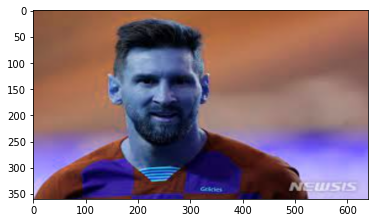

In [43]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.jpeg'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640,360))
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

- 이미지 채널은 RGB 이지만, opencv 는 BGR 을 사용하므로 붉은색과 푸른색이 바뀌어 출력된다. 색깔 보정처리를 해줘보자

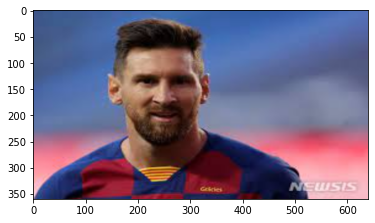

In [44]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [45]:
# hog detector
import dlib
detector_hog = dlib.get_frontal_face_detector()

In [46]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(167, 98) (322, 253)]]


<function matplotlib.pyplot.show(close=None, block=None)>

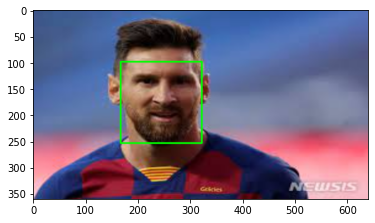

In [48]:
# 찾은 얼굴 출력
print(dlib_rects)

for dlib_rect in dlib_rects:
    left = dlib_rect.left()
    top = dlib_rect.top()
    right = dlib_rect.right()
    bottom = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (left,top),(right,bottom),(0,255,0),2,lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show

### Face landmark 

- Object keypoint estimation
    1. top-down : bounding box 를 찾고 box 내부의 keypoint를 예측
    2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성
    
- 우리는 top-down 방식을 다뤄보겠다.


#### Dlib landmark localization

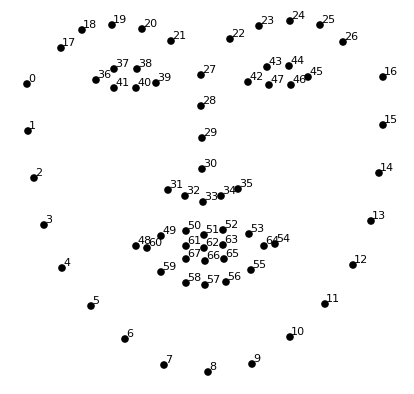

- Dlib model
https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf

In [49]:
model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

- landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 을 반환한다.

In [50]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p:(p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


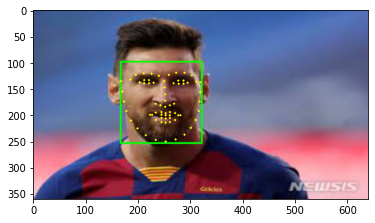

In [51]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0,255,255), -1)    #yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 스티커 씌우기
랜드마크를 기준으로 눈썹 위 얼굴 중앙에 스티커를 씌워보자. 우리는 코 중심을 기준으로 높이 x 이상에 그려볼 것이다.

- 스티커 위치
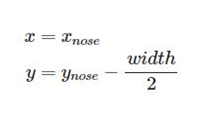

- 스티커 크기
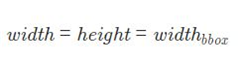

In [52]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])    #nose center index : 30   (위 dlib landmark localization 그림 참고)
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()/2
    w = dlib_rect.width()
    h = dlib_rect.height()
    print('(x,y) : (%d, %d)' %(x,y))
    print('(w,h) : (%d, %d)' %(w,h))

(252, 172)
(x,y) : (252, 94)
(w,h) : (156, 156)


#### 스티커 적용

In [54]:
sticker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/crown.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker,(w,h))    # 메시 사진에 맞게 왕관 이미지를 resize
print(img_sticker.shape)

(156, 156, 3)


In [59]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (174,-62)


- 이미지 범위를 벗어난 스티커 부분 제거

In [66]:
img_sticker = img_sticker[-int(refined_y):]
print (img_sticker.shape)

(32, 156, 3)


In [69]:
refined_y = 0

In [70]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

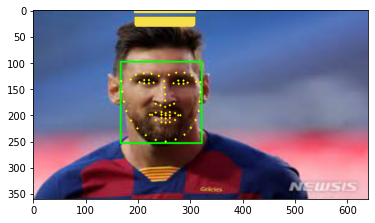

In [71]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 왕관이 많이 날아갔다..... 위에 여백이 있는 그림으로 해야할 듯 싶다...!